In [ ]:
import os
import shutil
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### Crop (texte) + Modifier format bmp -> numpy

In [1]:
# Fonction pour convertir et rogner les images BMP, puis les sauvegarder en format numérique
def convert_and_crop_images(img_folder, output_folder, crop_zone):
    # Lister tous les fichiers d'image BMP dans le dossier
    img_names = list(glob.glob(os.path.join(img_folder, '*.bmp')))
    
    print("Nombre d'images à convertir et rogner:", len(img_names))
    
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for img_name in img_names:
        # Ouvrir une image
        image = Image.open(img_name)
        
        # Rogner l'image
        cropped_image = image.crop(crop_zone)
        
        # Convertir l'image en mode RGB
        cropped_image = cropped_image.convert('RGB')
        
        # Convertir l'image rognée en tableau numpy
        img_array = np.array(cropped_image)
        
        # Créer le chemin pour sauvegarder l'image en format numpy
        base_name = os.path.basename(img_name).replace('.bmp', '.npy')
        cropped_img_path = os.path.join(output_folder, base_name)
        
        # Sauvegarder l'image rognée en format numpy
        np.save(cropped_img_path, img_array)

# Définir les dossiers et la zone de rognage
img_folder = 'D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/bmp'
output_folder = 'D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/numpy'
crop_zone = (0, 0, 1228, 750)

# Convertir et rogner les images BMP en format numpy
convert_and_crop_images(img_folder, output_folder, crop_zone)


Nombre d'images à convertir et rogner: 498


#### Visualisation

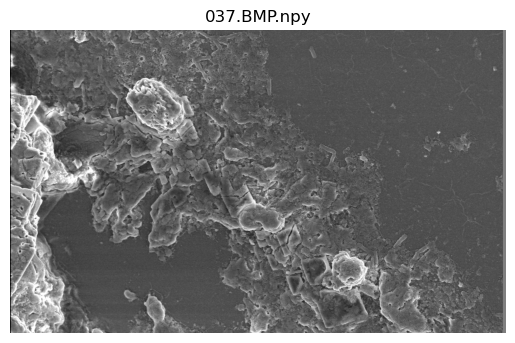

In [3]:
# Chemin vers le fichier numpy
file_path = 'D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/numpy/038.BMP.npy'

# Charger l'image numpy
image_array = np.load(file_path)

# Afficher l'image
plt.imshow(image_array)
plt.title('037.BMP.npy')
plt.axis('off')  # Masquer les axes
plt.show()


#### Clustering

1/1 [==============================] - 0s 389ms/step


1/1 [==============================] - 0s 300ms/step
Nombre d'images traitées: 498
Exemple de caractéristiques extraites: [0.15338665 0.         0.         ... 0.         0.78246546 0.        ]
Shape des caractéristiques: (498, 25088)


D:\Python\ANACONDA\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


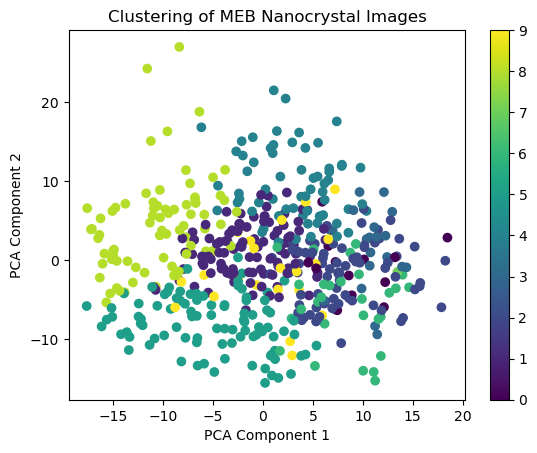

Clustering results saved to clustering_results.txt


In [7]:
# Fonction pour extraire les caractéristiques d'une image numpy à l'aide de VGG16
def extract_features(image_array, model):
    img = Image.fromarray(image_array).convert('L')  # Convertir en niveaux de gris
    img = img.resize((224, 224))  # Redimensionner l'image
    img = img_to_array(img)
    img = np.concatenate([img, img, img], axis=-1)  # Convertir en 3 canaux
    img = np.expand_dims(img, axis=0)
    img = img.astype('float32') / 255.0  # Normaliser les valeurs des pixels
    features = model.predict(img)
    return features.flatten()

# Dossier contenant les images numpy rognées
output_folder = 'D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/numpy'

# Charger le modèle VGG16 pré-entraîné sans la couche de sortie
model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Liste des chemins des fichiers numpy
image_paths = [os.path.join(output_folder, fname) for fname in os.listdir(output_folder) if fname.endswith('.npy')]

# Extraire les caractéristiques de toutes les images
features_list = []
for img_path in image_paths:
    img_array = np.load(img_path)
    features = extract_features(img_array, model)
    features_list.append(features)

print(f"Nombre d'images traitées: {len(features_list)}")
print(f"Exemple de caractéristiques extraites: {features_list[0] if features_list else 'Aucune caractéristique extraite'}")

# Vérifier si features_list est vide
if not features_list:
    print("Erreur: Aucune caractéristique n'a été extraite. Vérifiez les chemins d'accès aux images et l'étape d'extraction des caractéristiques.")
else:
    # Conversion en array numpy
    features_array = np.array(features_list)
    print(f"Shape des caractéristiques: {features_array.shape}")

    # Réduction de dimensionnalité avec PCA
    pca = PCA(n_components=400)
    reduced_features = pca.fit_transform(features_array)

    # Clustering avec K-means
    kmeans = KMeans(n_clusters=10)  # Définir le nombre de clusters souhaité
    clusters = kmeans.fit_predict(reduced_features)

    # Visualiser les clusters (optionnel)
    plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('Clustering of MEB Nanocrystal Images')
    plt.colorbar()
    plt.show()

    # Sauvegarder les résultats des clusters avec les noms des fichiers
    output_file = 'clustering_results.txt'
    with open(output_file, 'w') as f:
        for img_path, cluster in zip(image_paths, clusters):
            f.write(f"{img_path}\tCluster {cluster}\n")

    print(f"Clustering results saved to {output_file}")


### Classer en dossiers (1 dossier par cluster)

In [8]:
# Dossier contenant les fichiers BMP originaux
bmp_folder = 'D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/bmp'

# Dossier où les fichiers seront copiés
output_base_folder = 'D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test'

# Chemin vers le fichier de résultats de clustering
clustering_results_file = 'clustering_results.txt'

# Lire le fichier de résultats de clustering
with open(clustering_results_file, 'r') as f:
    lines = f.readlines()

# Parcourir chaque ligne du fichier de résultats
for line in lines:
    npy_path, cluster = line.strip().split('\t')
    
    # Extraire le nom de fichier sans l'extension et le chemin du dossier
    base_name = os.path.basename(npy_path).replace('.BMP.npy', '.BMP')
    cluster_number = cluster.split(' ')[-1]
    
    # Construire le chemin complet vers le fichier BMP original
    bmp_file = os.path.join(bmp_folder, base_name)
    
    # Vérifier si le fichier BMP existe
    if not os.path.exists(bmp_file):
        print(f"Fichier introuvable : {bmp_file}")
        continue
    
    # Construire le dossier de sortie pour le cluster
    cluster_folder = os.path.join(output_base_folder, f"cluster_{cluster_number}")
    
    # Créer le dossier de cluster s'il n'existe pas
    if not os.path.exists(cluster_folder):
        os.makedirs(cluster_folder)
    
    # Chemin complet vers le fichier BMP dans le dossier de cluster
    output_file = os.path.join(cluster_folder, base_name)
    
    # Copier le fichier BMP vers le dossier de cluster
    shutil.copy(bmp_file, output_file)
    print(f"Copié {bmp_file} vers {output_file}")

print("Copie terminée.")


Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/bmp\030.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test\cluster_5\030.BMP
Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/bmp\031.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test\cluster_9\031.BMP
Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/bmp\032.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test\cluster_5\032.BMP
Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/bmp\033.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test\cluster_1\033.BMP
Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/bmp\034.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test\cluster_6\034.BMP
Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/bmp\035.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test\cluster_1\035.BMP
Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/bmp\036.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test\cluster_1\036.BMP
Copié D:/Trav

Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/bmp\129.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test\cluster_4\129.BMP
Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/bmp\130.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test\cluster_4\130.BMP
Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/bmp\131.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test\cluster_5\131.BMP
Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/bmp\132.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test\cluster_4\132.BMP
Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/bmp\133.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test\cluster_4\133.BMP
Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/bmp\134.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test\cluster_5\134.BMP
Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/bmp\135.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test\cluster_2\135.BMP
Copié D:/Trav

Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/bmp\222.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test\cluster_1\222.BMP
Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/bmp\223.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test\cluster_1\223.BMP
Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/bmp\224.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test\cluster_1\224.BMP
Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/bmp\225.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test\cluster_4\225.BMP
Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/bmp\226.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test\cluster_8\226.BMP
Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/bmp\227.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test\cluster_8\227.BMP
Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/bmp\228.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test\cluster_4\228.BMP
Copié D:/Trav

Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/bmp\340.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test\cluster_5\340.BMP
Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/bmp\341.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test\cluster_4\341.BMP
Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/bmp\342.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test\cluster_4\342.BMP
Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/bmp\343.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test\cluster_4\343.BMP
Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/bmp\344.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test\cluster_5\344.BMP
Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/bmp\345.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test\cluster_3\345.BMP
Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/bmp\346.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test\cluster_2\346.BMP
Copié D:/Trav

Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/bmp\445.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test\cluster_1\445.BMP
Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/bmp\446.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test\cluster_1\446.BMP
Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/bmp\447.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test\cluster_4\447.BMP
Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/bmp\448.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test\cluster_4\448.BMP
Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/bmp\449.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test\cluster_5\449.BMP
Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/bmp\450.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test\cluster_5\450.BMP
Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/bmp\451.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test\cluster_5\451.BMP
Copié D:/Trav

Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/bmp\541.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test\cluster_8\541.BMP
Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/bmp\542.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test\cluster_2\542.BMP
Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/bmp\543.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test\cluster_8\543.BMP
Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/bmp\544.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test\cluster_1\544.BMP
Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/bmp\545.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test\cluster_1\545.BMP
Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/bmp\546.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test\cluster_8\546.BMP
Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/bmp\547.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test\cluster_4\547.BMP
Copié D:/Trav

# Test sur zoom x1

### Crop (texte) + Modifier format bmp -> numpy

In [1]:
# Fonction pour convertir et rogner les images BMP, puis les sauvegarder en format numérique
def convert_and_crop_images(img_folder, output_folder, crop_zone):
    # Lister tous les fichiers d'image BMP dans le dossier
    img_names = list(glob.glob(os.path.join(img_folder, '*.bmp')))
    
    print("Nombre d'images à convertir et rogner:", len(img_names))
    
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for img_name in img_names:
        # Ouvrir une image
        image = Image.open(img_name)
        
        # Rogner l'image
        cropped_image = image.crop(crop_zone)
        
        # Convertir l'image en mode RGB
        cropped_image = cropped_image.convert('RGB')
        
        # Convertir l'image rognée en tableau numpy
        img_array = np.array(cropped_image)
        
        # Créer le chemin pour sauvegarder l'image en format numpy
        base_name = os.path.basename(img_name).replace('.bmp', '.npy')
        cropped_img_path = os.path.join(output_folder, base_name)
        
        # Sauvegarder l'image rognée en format numpy
        np.save(cropped_img_path, img_array)

# Définir les dossiers et la zone de rognage
img_folder = 'D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/zoom_1/bmp'
output_folder = 'D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/zoom_1/numpy'
crop_zone = (0, 0, 1228, 750)

# Convertir et rogner les images BMP en format numpy
convert_and_crop_images(img_folder, output_folder, crop_zone)


Nombre d'images à convertir et rogner: 120


### Clustering

1/1 [==============================] - 1s 603ms/step
Nombre d'images traitées: 120
Exemple de caractéristiques extraites: [0.17860638 0.         0.         ... 0.         0.80414724 0.        ]
Shape des caractéristiques: (120, 25088)


D:\Python\ANACONDA\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


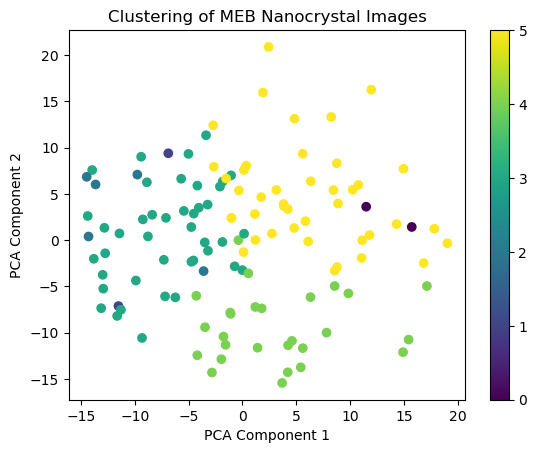

Clustering results saved to clustering_results_zoom1.txt


In [5]:
# Fonction pour extraire les caractéristiques d'une image numpy à l'aide de VGG16
def extract_features(image_array, model):
    img = Image.fromarray(image_array).convert('L')  # Convertir en niveaux de gris
    img = img.resize((224, 224))  # Redimensionner l'image
    img = img_to_array(img)
    img = np.concatenate([img, img, img], axis=-1)  # Convertir en 3 canaux
    img = np.expand_dims(img, axis=0)
    img = img.astype('float32') / 255.0  # Normaliser les valeurs des pixels
    features = model.predict(img)
    return features.flatten()

# Dossier contenant les images numpy rognées
output_folder = 'D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/zoom_1/numpy'

# Charger le modèle VGG16 pré-entraîné sans la couche de sortie
model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Liste des chemins des fichiers numpy
image_paths = [os.path.join(output_folder, fname) for fname in os.listdir(output_folder) if fname.endswith('.npy')]

# Extraire les caractéristiques de toutes les images
features_list = []
for img_path in image_paths:
    img_array = np.load(img_path)
    features = extract_features(img_array, model)
    features_list.append(features)

print(f"Nombre d'images traitées: {len(features_list)}")
print(f"Exemple de caractéristiques extraites: {features_list[0] if features_list else 'Aucune caractéristique extraite'}")

# Vérifier si features_list est vide
if not features_list:
    print("Erreur: Aucune caractéristique n'a été extraite. Vérifiez les chemins d'accès aux images et l'étape d'extraction des caractéristiques.")
else:
    # Conversion en array numpy
    features_array = np.array(features_list)
    print(f"Shape des caractéristiques: {features_array.shape}")

    # Réduction de dimensionnalité avec PCA
    pca = PCA(n_components=120)
    reduced_features = pca.fit_transform(features_array)

    # Clustering avec K-means
    kmeans = KMeans(n_clusters=6)  # Définir le nombre de clusters souhaité
    clusters = kmeans.fit_predict(reduced_features) #remplacer par reduced_features si on use pca

    # Visualiser les clusters (optionnel)
    plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('Clustering of MEB Nanocrystal Images')
    plt.colorbar()
    plt.show()
    
    
    # Sauvegarder les résultats des clusters avec les noms des fichiers
    output_file = 'clustering_results_zoom1.txt'
    with open(output_file, 'w') as f:
        for img_path, cluster in zip(image_paths, clusters):
            f.write(f"{img_path}\tCluster {cluster}\n")

    print(f"Clustering results saved to {output_file}")


1/1 [==============================] - 0s 141ms/step
Nombre d'images traitées: 120
Exemple de caractéristiques extraites: [0.17860638 0.         0.         ... 0.         0.80414724 0.        ]
Shape des caractéristiques: (120, 25088)


C:\Users\sterb\AppData\Local\Temp\ipykernel_17288\1531046431.py:57: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(reduced_features[:, 0], reduced_features[:, 1], cmap='viridis')


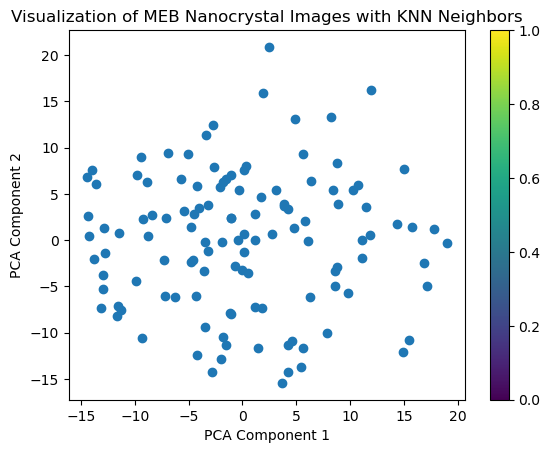

KNN results saved to knn_results_zoom1.txt


In [2]:
# Fonction pour extraire les caractéristiques d'une image numpy à l'aide de VGG16
def extract_features(image_array, model):
    img = Image.fromarray(image_array).convert('L')  # Convertir en niveaux de gris
    img = img.resize((224, 224))  # Redimensionner l'image
    img = img_to_array(img)
    img = np.concatenate([img, img, img], axis=-1)  # Convertir en 3 canaux
    img = np.expand_dims(img, axis=0)
    img = img.astype('float32') / 255.0  # Normaliser les valeurs des pixels
    features = model.predict(img)
    return features.flatten()

# Dossier contenant les images numpy rognées
output_folder = 'D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/zoom_1/numpy'

# Charger le modèle VGG16 pré-entraîné sans la couche de sortie
model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Liste des chemins des fichiers numpy
image_paths = [os.path.join(output_folder, fname) for fname in os.listdir(output_folder) if fname.endswith('.npy')]

# Extraire les caractéristiques de toutes les images
features_list = []
for img_path in image_paths:
    img_array = np.load(img_path)
    features = extract_features(img_array, model)
    features_list.append(features)

print(f"Nombre d'images traitées: {len(features_list)}")
print(f"Exemple de caractéristiques extraites: {features_list[0] if features_list else 'Aucune caractéristique extraite'}")

# Vérifier si features_list est vide
if not features_list:
    print("Erreur: Aucune caractéristique n'a été extraite. Vérifiez les chemins d'accès aux images et l'étape d'extraction des caractéristiques.")
else:
    # Conversion en array numpy
    features_array = np.array(features_list)
    print(f"Shape des caractéristiques: {features_array.shape}")

    # Réduction de dimensionnalité avec PCA
    pca = PCA(n_components=120)
    reduced_features = pca.fit_transform(features_array)

    # Utilisation de KNN pour la recherche des voisins les plus proches
    nbrs = NearestNeighbors(n_neighbors=5, algorithm='auto').fit(reduced_features)
    distances, indices = nbrs.kneighbors(reduced_features)

    # Visualiser les résultats (optionnel)
    plt.scatter(reduced_features[:, 0], reduced_features[:, 1], cmap='viridis')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('Visualization of MEB Nanocrystal Images with KNN Neighbors')
    plt.colorbar()
    plt.show()

    # Sauvegarder les résultats des voisins les plus proches avec les noms des fichiers
    output_file = 'knn_results_zoom1.txt'
    with open(output_file, 'w') as f:
        for i, img_path in enumerate(image_paths):
            neighbors = indices[i]
            f.write(f"{img_path}\tNeighbors: {', '.join(image_paths[n] for n in neighbors)}\n")

    print(f"KNN results saved to {output_file}")


In [5]:
# Fonction pour extraire les caractéristiques d'une image numpy à l'aide de VGG16
def extract_features(image_array, model):
    img = Image.fromarray(image_array).convert('L')  # Convertir en niveaux de gris
    img = img.resize((224, 224))  # Redimensionner l'image
    img = img_to_array(img)
    img = np.concatenate([img, img, img], axis=-1)  # Convertir en 3 canaux
    img = np.expand_dims(img, axis=0)
    img = img.astype('float32') / 255.0  # Normaliser les valeurs des pixels
    features = model.predict(img)
    return features.flatten()

# Dossier contenant les images numpy rognées
output_folder = 'D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/zoom_1/numpy'

# Charger le modèle VGG16 pré-entraîné sans la couche de sortie
model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Liste des chemins des fichiers numpy
image_paths = [os.path.join(output_folder, fname) for fname in os.listdir(output_folder) if fname.endswith('.npy')]

# Extraire les caractéristiques de toutes les images
features_list = []
for img_path in image_paths:
    img_array = np.load(img_path)
    features = extract_features(img_array, model)
    features_list.append(features)

print(f"Nombre d'images traitées: {len(features_list)}")
print(f"Exemple de caractéristiques extraites: {features_list[0] if features_list else 'Aucune caractéristique extraite'}")

# Vérifier si features_list est vide
if not features_list:
    print("Erreur: Aucune caractéristique n'a été extraite. Vérifiez les chemins d'accès aux images et l'étape d'extraction des caractéristiques.")
else:
    # Conversion en array numpy
    features_array = np.array(features_list)
    print(f"Shape des caractéristiques: {features_array.shape}")

    # Réduction de dimensionnalité avec PCA
    pca = PCA(n_components=120)
    reduced_features = pca.fit_transform(features_array)

    # Calculer le score de silhouette pour différents nombres de clusters


    # Tracer la courbe du score de silhouette
    plt.figure(figsize=(8, 4))
    plt.plot(K, silhouette_scores, 'bx-')
    plt.xlabel('Nombre de clusters')
    plt.ylabel('Score de silhouette')
    plt.title('Score de silhouette pour déterminer le nombre optimal de clusters')
    plt.show()

    # Déterminer le nombre optimal de clusters (celui avec le score de silhouette le plus élevé)
    optimal_k = 10
    print(f"Nombre optimal de clusters : {optimal_k}")

    # Clustering avec K-means en utilisant le nombre optimal de clusters
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    clusters = kmeans.fit_predict(reduced_features)

    # Visualiser les clusters
    plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('Clustering of MEB Nanocrystal Images')
    plt.colorbar()
    plt.show()

    # Sauvegarder les résultats des clusters avec les noms des fichiers
    output_file = 'clustering_results_zoom1.txt'
    with open(output_file, 'w') as f:
        for img_path, cluster in zip(image_paths, clusters):
            f.write(f"{img_path}\tCluster {cluster}\n")

    print(f"Clustering results saved to {output_file}")


1/1 [==============================] - 0s 148ms/step
Nombre d'images traitées: 120
Exemple de caractéristiques extraites: [0.17860638 0.         0.         ... 0.         0.80414724 0.        ]
Shape des caractéristiques: (120, 25088)


NameError: name 'K' is not defined

<Figure size 800x400 with 0 Axes>

### Separer en dossiers pour voir les clusters

In [3]:
# Dossier contenant les fichiers BMP originaux
bmp_folder = 'D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/zoom_1/bmp'

# Dossier où les fichiers seront copiés
output_base_folder = 'D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/zoom_1'

# Chemin vers le fichier de résultats de clustering
clustering_results_file = 'clustering_results_zoom1.txt'

# Lire le fichier de résultats de clustering
with open(clustering_results_file, 'r') as f:
    lines = f.readlines()

# Parcourir chaque ligne du fichier de résultats
for line in lines:
    npy_path, cluster = line.strip().split('\t')
    
    # Extraire le nom de fichier sans l'extension et le chemin du dossier
    base_name = os.path.basename(npy_path).replace('.BMP.npy', '.BMP')
    cluster_number = cluster.split(' ')[-1]
    
    # Construire le chemin complet vers le fichier BMP original
    bmp_file = os.path.join(bmp_folder, base_name)
    
    # Vérifier si le fichier BMP existe
    if not os.path.exists(bmp_file):
        print(f"Fichier introuvable : {bmp_file}")
        continue
    
    # Construire le dossier de sortie pour le cluster
    cluster_folder = os.path.join(output_base_folder, f"cluster_{cluster_number}")
    
    # Créer le dossier de cluster s'il n'existe pas
    if not os.path.exists(cluster_folder):
        os.makedirs(cluster_folder)
    
    # Chemin complet vers le fichier BMP dans le dossier de cluster
    output_file = os.path.join(cluster_folder, base_name)
    
    # Copier le fichier BMP vers le dossier de cluster
    shutil.copy(bmp_file, output_file)
    print(f"Copié {bmp_file} vers {output_file}")

print("Copie terminée.")


Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/zoom_1/bmp\032.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/zoom_1\cluster_1\032.BMP
Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/zoom_1/bmp\033.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/zoom_1\cluster_1\033.BMP
Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/zoom_1/bmp\034.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/zoom_1\cluster_0\034.BMP
Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/zoom_1/bmp\035.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/zoom_1\cluster_1\035.BMP
Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/zoom_1/bmp\039.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/zoom_1\cluster_1\039.BMP
Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/zoom_1/bmp\040.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/zoom_1\cluster_1\040.BMP
Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/zoom_1/bmp\041

Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/zoom_1/bmp\202.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/zoom_1\cluster_0\202.BMP
Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/zoom_1/bmp\204.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/zoom_1\cluster_0\204.BMP
Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/zoom_1/bmp\208.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/zoom_1\cluster_1\208.BMP
Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/zoom_1/bmp\211.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/zoom_1\cluster_1\211.BMP
Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/zoom_1/bmp\213.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/zoom_1\cluster_1\213.BMP
Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/zoom_1/bmp\215.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/zoom_1\cluster_0\215.BMP
Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/zoom_1/bmp\216

Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/zoom_1/bmp\R-04.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/zoom_1\cluster_1\R-04.BMP
Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/zoom_1/bmp\R-08..BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/zoom_1\cluster_1\R-08..BMP
Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/zoom_1/bmp\R-11.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/zoom_1\cluster_0\R-11.BMP
Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/zoom_1/bmp\R-12.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/zoom_1\cluster_1\R-12.BMP
Copié D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/zoom_1/bmp\US04.BMP vers D:/Travail/Cours/M1/s2/Projet Innov/docs/img_test/zoom_1\cluster_1\US04.BMP
Copie terminée.
